<a href="https://colab.research.google.com/github/IANGECHUKI176/deeplearning/blob/main/pytorch/nlp/pytorch-seq2seq/5_Convolutional_Sequence_to_Sequence_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference: [Bentrevett Github](https://github.com/bentrevett/pytorch-seq2seq/blob/master/5%20-%20Convolutional%20Sequence%20to%20Sequence%20Learning.ipynb)

[Convolutional Sequence to Sequence Learning](https://arxiv.org/pdf/1705.03122.pdf)

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time
from tqdm import tqdm
from torch import nn
import torchtext
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import vocab
from torchtext.utils import download_from_url, extract_archive
import io

In [2]:
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

2023-08-31 10:58:42.694601: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-31 10:58:43.604844: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-31 10:58:45.068307: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-31 10:58:45.068762: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returnin

In [3]:

url_base = 'https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/'
train_urls = ('train.de.gz', 'train.en.gz')
val_urls = ('val.de.gz', 'val.en.gz')
test_urls = ('test_2016_flickr.de.gz', 'test_2016_flickr.en.gz')

train_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in train_urls]
val_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in val_urls]
test_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in test_urls]

de_tokenizer = get_tokenizer('spacy', language='de_core_news_sm')
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

def build_vocab(filepath, tokenizer):
    counter = Counter()
    with io.open(filepath, encoding="utf8") as f:
        for string_ in f:
            counter.update(tokenizer(string_))
    v2 = vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])
    v2.set_default_index(0)
    return v2

de_vocab = build_vocab(train_filepaths[0], de_tokenizer)
en_vocab = build_vocab(train_filepaths[1], en_tokenizer)

def data_process(filepaths):
    raw_de_iter = iter(io.open(filepaths[0], encoding="utf8"))
    raw_en_iter = iter(io.open(filepaths[1], encoding="utf8"))
    data = []
    for (raw_de, raw_en) in zip(raw_de_iter, raw_en_iter):
        de_tensor_ = torch.tensor([de_vocab[token] for token in de_tokenizer(raw_de)],
                                dtype=torch.long)
        en_tensor_ = torch.tensor([en_vocab[token] for token in en_tokenizer(raw_en)],
                                dtype=torch.long)
        data.append((de_tensor_, en_tensor_))
    return data

train_data = data_process(train_filepaths)
val_data = data_process(val_filepaths)
test_data = data_process(test_filepaths)

100%|██████████| 637k/637k [00:00<00:00, 8.10MB/s]
100%|██████████| 569k/569k [00:00<00:00, 9.15MB/s]
100%|██████████| 24.7k/24.7k [00:00<00:00, 2.89MB/s]
100%|██████████| 21.6k/21.6k [00:00<00:00, 20.8MB/s]
100%|██████████| 22.9k/22.9k [00:00<00:00, 1.78MB/s]
100%|██████████| 21.1k/21.1k [00:00<00:00, 3.09MB/s]


In [4]:

BATCH_SIZE = 128
PAD_IDX = de_vocab['<pad>']
BOS_IDX = de_vocab['<bos>']
EOS_IDX = de_vocab['<eos>']

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def generate_batch(data_batch):
    de_batch, en_batch = [], []
    for (de_item, en_item) in data_batch:
        de_batch.append(torch.cat([torch.tensor([BOS_IDX]), de_item, torch.tensor([EOS_IDX])], dim=0))
        en_batch.append(torch.cat([torch.tensor([BOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0))

    de_batch = pad_sequence(de_batch, padding_value=PAD_IDX,batch_first = True)
    en_batch = pad_sequence(en_batch, padding_value=PAD_IDX,batch_first = True)
    return de_batch, en_batch

train_iter = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE,
                       shuffle=True, collate_fn=generate_batch)

In [5]:
x , y = next(iter(train_iter))
# x,y= x.T,y.T
x.shape,y.shape


(torch.Size([128, 29]), torch.Size([128, 37]))

Encoder

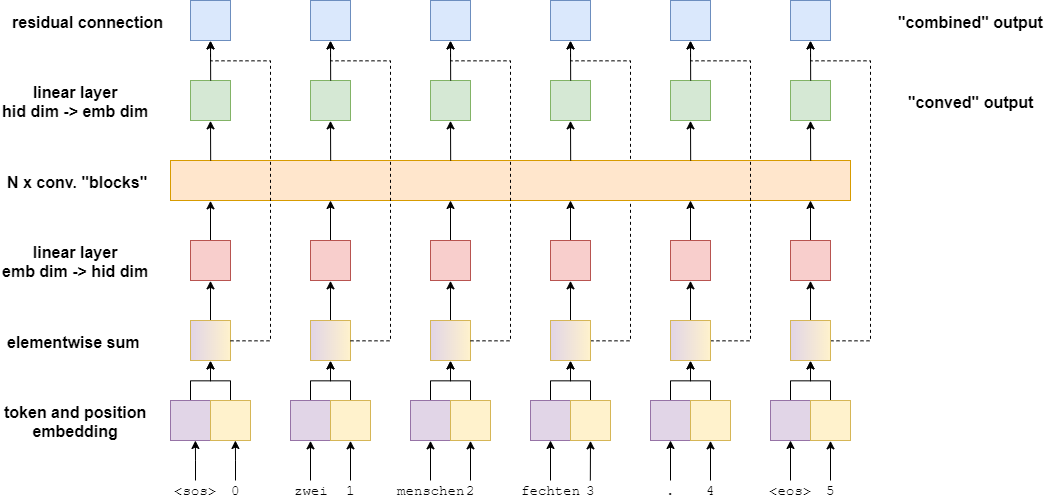

Convblocks
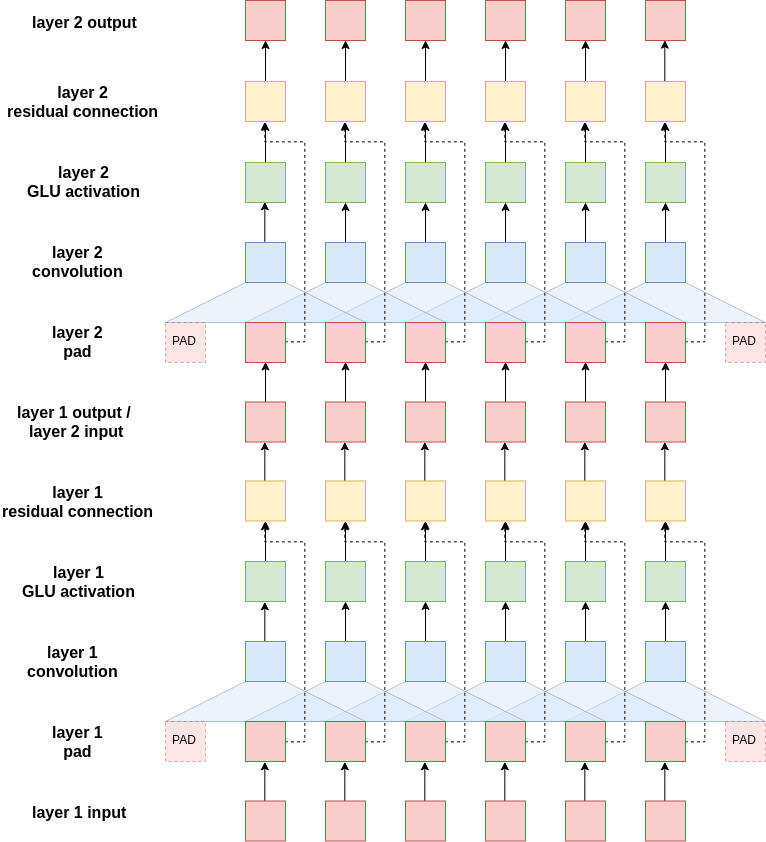

In [6]:
class Encoder(nn.Module):
    def __init__(self,input_dim,emb_dim,hid_dim,n_layers,kernel_size,dropout,max_length = 100):
        super(Encoder,self).__init__()

        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)

        self.tok_embedding = nn.Embedding(input_dim,emb_dim)
        self.pos_embedding = nn.Embedding(max_length,emb_dim)

        self.emb2hid = nn.Linear(emb_dim,hid_dim)
        self.hid2emb = nn.Linear(hid_dim,emb_dim)

        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim,
                                              out_channels = hid_dim * 2,
                                              kernel_size = kernel_size,
                                              padding = (kernel_size - 1)//2)
                        for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)

    def forward(self,src):
        #src = [batch size,src len]
        batch_size = src.shape[0]
        src_len = src.shape[1]
        #create position tensor
        pos = torch.arange(0,src_len).unsqueeze(0).repeat(batch_size,1).to(device)

        #pos =  [0,1,2,3,...,src_len-1]
        #pos  = [batch_size,src_len]

        #embed tokens and pos
        tok_embedded = self.tok_embedding(src)
        pos_embedded = self.pos_embedding(pos)

        #tok_embedded = pos_embedded = [batch_size,src_len,emb_dim]

        #combine embeddings by elementwise summing
        embedded = self.dropout(tok_embedded + pos_embedded)

        #embedded = [batch size, src len, emb dim]

        #pass embedded through linear layer to convert from emb dim to hid dim
        conv_input = self.emb2hid(embedded)

        #conv_input = [batch size,src len,hid dim]

        #permute for convolution layer
        conv_input = conv_input.permute(0,2,1)

        #conv_input = [batch size,hid dim,src len]

        #begin convolution blocks...
        for i,conv in enumerate(self.convs):
            #pass through conv layer
            conved = conv(self.dropout(conv_input))

            #conved = [batch size,hid dim * 2,src len]

            #pass through GLU activation function
            conved = F.glu(conved,dim = 1)
            #conved = [batch size,hid dim ,src len]

            #apply residual conn
            conved = (conved + conv_input) * self.scale

            #conved = [batch size,hid dim ,src len]

            #set conv_input to conved for next loop iteration
            conv_input = conved

        #...end convolutional blocks

        conved = conved.permute(0,2,1)
        #conved =  [batch size,src len,hid dim]

        conved = self.hid2emb(conved)

        #conved =  [batch size,src len,emb dim]

        combined = (conved + embedded) * self.scale
        #combined = [batch size,src len,emb dim]

        return conved, combined

In [7]:
class Decoder(nn.Module):
    def __init__(self,output_dim,emb_dim,hid_dim,n_layers,kernel_size,dropout,trg_pad_idx,max_length = 100):
        super(Decoder,self).__init__()

        self.kernel_size = kernel_size
        self.trg_pad_idx = trg_pad_idx

        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        self.tok_embedding = nn.Embedding(output_dim,emb_dim)
        self.pos_embedding = nn.Embedding(max_length,emb_dim)

        self.emb2hid = nn.Linear(emb_dim,hid_dim)
        self.hid2emb = nn.Linear(hid_dim,emb_dim)

        self.attn_hid2emb = nn.Linear(hid_dim,emb_dim)
        self.attn_emb2hid = nn.Linear(emb_dim,hid_dim)

        self.fc_out = nn.Linear(emb_dim,output_dim)
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim,
                                              out_channels = hid_dim * 2,
                                              kernel_size = kernel_size)
                                            for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)

    def calculate_attention(self,embedded,conved,encoder_conved,encoder_combined):
        #embedded = [batch size, trg len, emb dim]
        #conved = [batch size, hid dim, trg len]
        #encoder_conved = encoder_combined = [batch size, src len, emb dim]

        #permute and convert back to emb dim
        conved_emb = self.attn_hid2emb(conved.permute(0,2,1))

        #conved_emb = [batch size,trg len,emb dim]

        combined = (conved_emb + embedded) * self.scale

        #combined = [batch size,trg len,emb dim]

        energy = torch.matmul(combined,encoder_conved.permute(0,2,1))

        #energy =  [batch size,trg len,emb dim]

        attention = F.softmax(energy,dim=2)

        #attention = [batch size, trg len, src len]

        attended_encoding = torch.matmul(attention,encoder_combined)
        #[batch size, trg len, src len] @ [batch size, src len, emb dim] --> [batch size, trg len, emb dim]

        #attention = [batch size, trg len, emb dim]

        #convert from emb dim -> hid dim
        attended_encoding = self.attn_emb2hid(attended_encoding)

        #attended_encoding = [batch size, trg len, hid dim]

        #apply residual connection
        attended_combined = (conved + attended_encoding.permute(0,2,1)) * self.scale

        #attended_combined = [batch size,hid dim,trg len]
        return attention, attended_combined

    def forward(self,trg,encoder_conved,encoder_combined):
        #trg = [batch size,trg len]
        #encoder_conved = encoder_combined = [batch_size,src len,emb_dim]
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        #create position tensor
        pos = torch.arange(0,trg_len).unsqueeze(0).repeat(batch_size,1).to(device)

        #pos = [batch size, trg len]

        tok_embedded = self.tok_embedding(trg)
        pos_embedded = self.pos_embedding(pos)

        #tok_embedded = [batch size, trg len, emb dim]
        #pos_embedded = [batch size, trg len, emb dim]

        #combine embeddings by elementwise summing
        embedded = self.dropout(tok_embedded + pos_embedded)

        #embedded = [batch size, trg len, emb dim]

        #pass embedded through linear layer to go through emb dim -> hid dim
        conv_input = self.emb2hid(embedded)

        #conv_input = [batch size, trg len, hid dim]

        #permute for convolutional layer
        conv_input = conv_input.permute(0,2,1)

        #conv_input = [batch size, hid dim, trg len]
        batch_size = conv_input.shape[0]
        hid_dim = conv_input.shape[1]

        for i,conv in enumerate(self.convs):
            #apply dropout
            conv_input = self.dropout(conv_input)
            #need to pad so decoder can't "cheat"
            padding = torch.zeros(batch_size,
                                  hid_dim,
                                  self.kernel_size - 1).fill_(self.trg_pad_idx).to(device)
            padding_conv_input = torch.cat((padding,conv_input),dim = 2)

            #padded_conv_input = [batch size, hid dim, trg len + kernel size - 1]
            #pass through convolutional layer
            conved = conv(padding_conv_input)

            #conved = [batch size, 2 * hid dim, trg len]

            #pass through GLU activation function
            conved = F.glu(conved,dim=1)

            #conved = [batch size, hid dim, trg len]

            #calculate attention
            attention,conved = self.calculate_attention(embedded,
                                                        conved,
                                                        encoder_conved,
                                                        encoder_combined)
            #attention = [batch size,trg len src len]

            #apply residual connection
            conved = (conved + conv_input) * self.scale

            #conved = [batch size,hid dim,trg len]

            #set conv_input to conved for next loop iteration
            conv_input = conved

        conved = self.hid2emb(conved.permute(0,2,1))

        #conved = [batch size, trg len, emb dim]

        output = self.fc_out(self.dropout(conved))

        #output = [batch size,trg len,output dim]

        return output,attention

In [8]:
class Seq2Seq(nn.Module):
    def __init__(self,encoder,decoder):
        super(Seq2Seq,self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self,src,trg):
        #src = [batch size, src len]
        #trg = [batch size, trg len - 1] (<eos> token sliced off the end)

        #calculate z^u (encoder_conved) and (z^u + e) (encoder_combined)
        #encoder_conved is output from final encoder conv. block
        #encoder_combined is encoder_conved plus (elementwise) src embedding plus
        #  positional embeddings
        encoder_conved,encoder_combined = self.encoder(src)

        #encoder_conved = [batch size, src len, emb dim]
        #encoder_combined = [batch size, src len, emb dim]

        #calculate predictions of next words
        #output is a batch of predictions for each word in the trg sentence
        #attention a batch of attention scores across the src sentence for
        #  each word in the trg sentence
        output,attention = self.decoder(trg,encoder_conved,encoder_combined)

        #output = [batch size, trg len - 1, output dim]
        #attention = [batch size, trg len - 1, src len]
        return output,attention


In [19]:
INPUT_DIM = len(de_vocab)
OUTPUT_DIM = len(en_vocab)
EMB_DIM = 256
HID_DIM = 512 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 10 # number of conv. blocks in encoder
DEC_LAYERS = 10 # number of conv. blocks in decoder
ENC_KERNEL_SIZE = 3 # must be odd!
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = en_vocab.get_stoi()['<pad>']

enc = Encoder(INPUT_DIM,EMB_DIM,HID_DIM,ENC_LAYERS,ENC_KERNEL_SIZE,ENC_DROPOUT)
# enc_conved,comb_conved = enc(x)
dec = Decoder(OUTPUT_DIM,EMB_DIM,HID_DIM,DEC_LAYERS,DEC_KERNEL_SIZE,DEC_DROPOUT,TRG_PAD_IDX)
# output,attention = dec(y,enc_conved,comb_conved)
model = Seq2Seq(enc,dec).to(device)
# output,attention = model(x,y)
# print(output.shape)
# print(attention.shape)

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 42,796,630 trainable parameters


In [21]:
TRG_PAD_IDX = en_vocab.get_stoi()['<pad>']
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

In [22]:
def train(model:nn.Module,
          iterator:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          criterion:nn.Module,
          clip:float):
    model.train()
    epoch_loss = 0
    for i,(src,trg) in enumerate(tqdm(iterator)):
        src,trg = src.to(device),trg.to(device)
        optimizer.zero_grad()

        # mask = (trg != TRG_PAD_IDX)
        # trg = trg*mask


        # mask_2 = (src != TRG_PAD_IDX)
        # src = src* mask_2



        output, _ = model(src, trg[:,:-1])
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)

        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [23]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for i,(src,trg) in enumerate(tqdm(iterator)):
            src,trg = src.to(device),trg.to(device)

            # mask = (trg != TRG_PAD_IDX)
            # trg = trg*mask


            # mask_2 = (src != TRG_PAD_IDX)
            # src = src* mask_2



            output, _ = model(src, trg[:,:-1])

            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [24]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [25]:
N_EPOCHS = 5
CLIP = 0.1

best_valid_loss = float('inf')
train_losses = []
val_losses = []
for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iter, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iter, criterion)
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')



100%|██████████| 8/8 [00:01<00:00,  7.97it/s]


Epoch: 01 | Time: 1m 21s
	Train Loss: 3.986 | Train PPL:  53.862
	 Val. Loss: 2.919 |  Val. PPL:  18.518


100%|██████████| 8/8 [00:01<00:00,  7.97it/s]


Epoch: 02 | Time: 1m 21s
	Train Loss: 2.897 | Train PPL:  18.125
	 Val. Loss: 2.406 |  Val. PPL:  11.093


100%|██████████| 8/8 [00:00<00:00,  8.14it/s]


Epoch: 03 | Time: 1m 20s
	Train Loss: 2.515 | Train PPL:  12.365
	 Val. Loss: 2.211 |  Val. PPL:   9.126


100%|██████████| 8/8 [00:01<00:00,  7.84it/s]


Epoch: 04 | Time: 1m 21s
	Train Loss: 2.287 | Train PPL:   9.849
	 Val. Loss: 2.085 |  Val. PPL:   8.043


100%|██████████| 8/8 [00:00<00:00,  8.11it/s]


Epoch: 05 | Time: 1m 20s
	Train Loss: 2.126 | Train PPL:   8.379
	 Val. Loss: 2.023 |  Val. PPL:   7.561


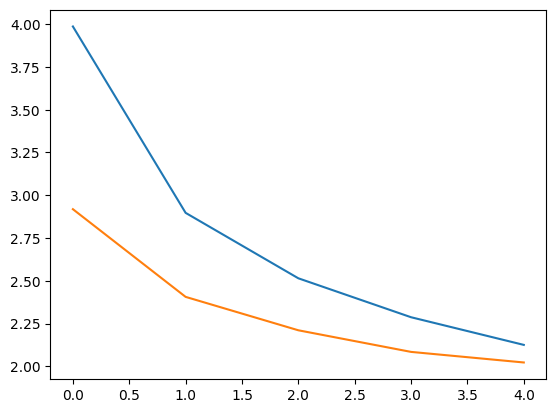

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.plot(train_losses)
plt.plot(val_losses)

<ipython-input-50-1fdd71f8e309>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-50-1fdd71f8e309>:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation,fontsize = 10)


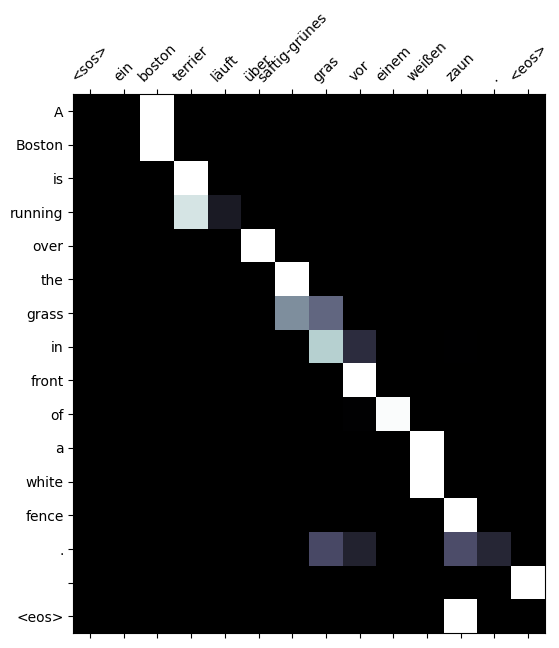

In [50]:
# Define the translation function
def translate_sentence(model, src_sentence,device, max_len=50):
    model.eval()
    with torch.no_grad():
        if isinstance(src_sentence, str):
            tokens = de_tokenizer(src_sentence)
        else:
            tokens = src_sentence


        tokens = ['<bos>'] + tokens + ['<eos>']
        src_indexes = de_vocab.lookup_indices(tokens)

        src_tensor = torch.tensor(src_indexes).unsqueeze(0).to(device)


        with torch.no_grad():
            encoder_conved, encoder_combined = model.encoder(src_tensor)


        BOS_INDEX = en_vocab.get_stoi()["<bos>"]

        trg_indexes = [BOS_INDEX]


        for i in range(max_len):

            trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

            with torch.no_grad():
                output, attention = model.decoder(trg_tensor, encoder_conved, encoder_combined)


            # pred_token = output.argmax(1)[:,-1].item()
            tokens = output.argmax(2)
            tokens = tokens.view(-1)
            pred_token = tokens[-1]
            trg_indexes.append(pred_token)

            if pred_token == en_vocab.get_stoi()["<eos>"]:
                break

    trg_tokens = en_vocab.lookup_tokens(trg_indexes)

    return trg_tokens[1:] , attention


# Define the function to display attention


def display_attention(sentence, translation, attention):

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(0).cpu().detach().numpy()

    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
                       rotation=45,fontsize=10)
    ax.set_yticklabels(['']+translation,fontsize = 10)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()



# Now you can use these functions to translate and display attention
src_sentence ="Ein Boston Terrier läuft über saftig-grünes Gras vor einem weißen Zaun."# Replace with your own source sentence tokens
translation, attention=translate_sentence(model, src_sentence, device)


src = de_tokenizer(src_sentence)
display_attention(src, translation, attention)



In [45]:
def get_test_data(filepaths): #test_filepaths
    raw_de_iter = iter(io.open(filepaths[0], encoding="utf8"))
    raw_en_iter = iter(io.open(filepaths[1], encoding="utf8"))
    return raw_de_iter,raw_en_iter

In [46]:
test_x,test_y = get_test_data(test_filepaths)
src_arr = []
trg_arr = []
for x,y in zip(test_x,test_y):
    src_arr.append(x)
    trg_arr.append(y)

src Eine Mutter und ihr kleiner Sohn genießen einen schönen Tag im Freien.

trg A mother and her young song enjoying a beautiful day outside.

predicted trg = ['A', 'mother', 'and', 'her', 'little', 'son', 'enjoying', 'a', 'beautiful', 'day', '.', '\n', '<eos>']


<ipython-input-44-a12bbd7befa8>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-44-a12bbd7befa8>:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation,fontsize = 10)


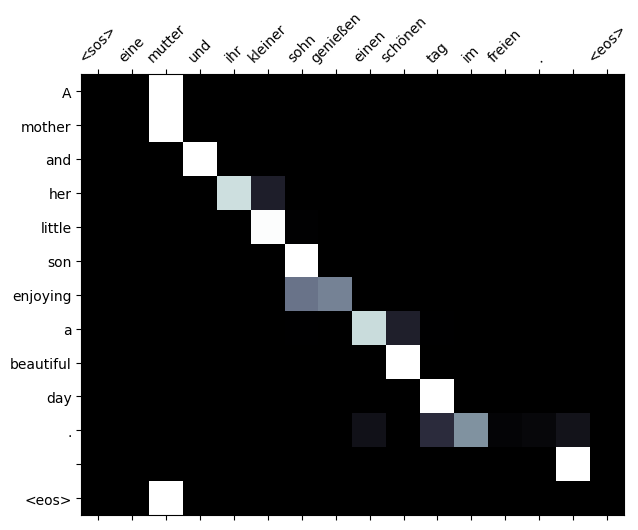

In [47]:
example_idx = 10
src = src_arr[example_idx]
trg = trg_arr[example_idx]
print('src',src)
print('trg',trg)
translation, attention = translate_sentence(model,src, device)

print(f'predicted trg = {translation}')
src = de_tokenizer(src)
display_attention(src, translation, attention)

src Leute, die vor einem Gebäude stehen.

trg People standing outside of a building.

predicted trg = ['People', 'standing', 'in', 'front', 'of', 'a', 'building', 'stand', '.', '\n', '<eos>']


<ipython-input-44-a12bbd7befa8>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-44-a12bbd7befa8>:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation,fontsize = 10)


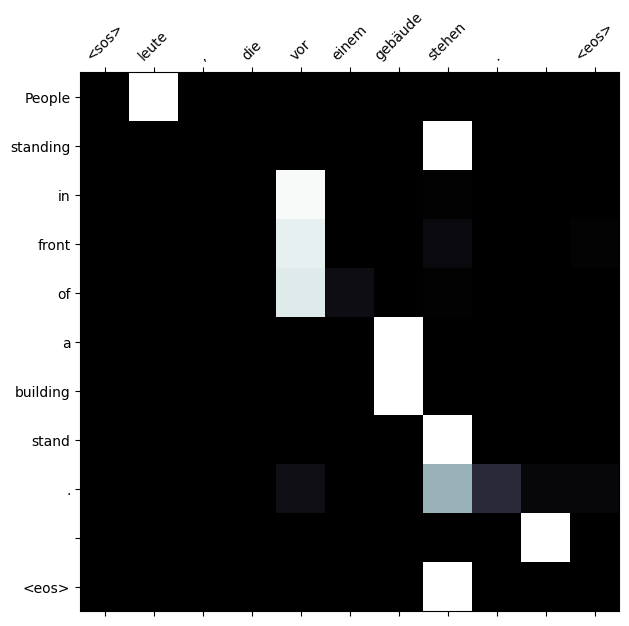

In [48]:
example_idx = 20
src = src_arr[example_idx]
trg = trg_arr[example_idx]
print('src',src)
print('trg',trg)
translation, attention = translate_sentence(model,src, device)

print(f'predicted trg = {translation}')

src = de_tokenizer(src)
display_attention(src, translation, attention)

src Die Person im gestreiften Shirt klettert auf einen Berg.

trg The person in the striped shirt is mountain climbing.

predicted trg = ['The', 'person', 'in', 'a', 'striped', 'shirt', 'climbing', 'a', 'mountain', '.', '\n', '<eos>']


<ipython-input-44-a12bbd7befa8>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-44-a12bbd7befa8>:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation,fontsize = 10)


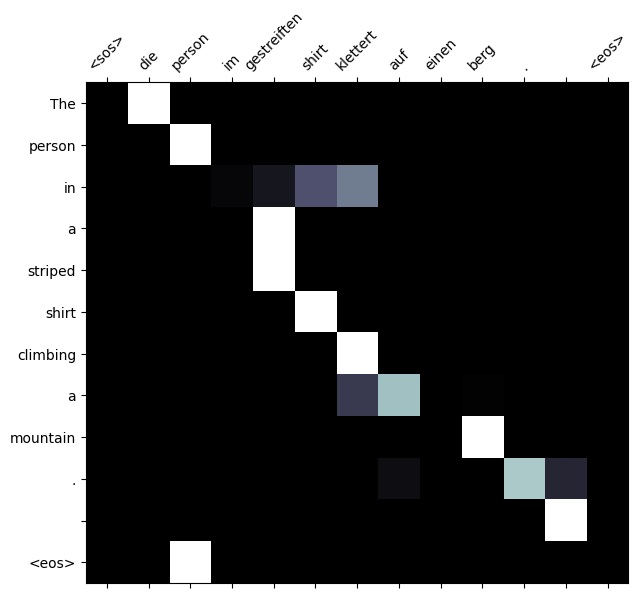

In [49]:
example_idx = 18
src = src_arr[example_idx]
trg = trg_arr[example_idx]
print('src',src)
print('trg',trg)
translation, attention = translate_sentence(model,src, device)

print(f'predicted trg = {translation}')

src = de_tokenizer(src)
display_attention(src, translation, attention)